### EfficientNet-B0


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
from torch.utils.data import random_split

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Training hyperparameters
num_epochs = 30
batch_size = 128
learning_rate = 0.001
weight_decay = 1e-4

# CIFAR-100 has 100 classes
num_classes = 100

# Path to save model
model_save_path = './efficientnet_b0_cifar100.pth'

In [3]:
# CIFAR-100 normalization statistics
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

# Define transforms for training and testing
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, 
                                  download=True, transform=train_transform)
test_dataset = datasets.CIFAR100(root='./data', train=False,
                                download=True, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4, pin_memory=True)

# Get class names
class_names = train_dataset.classes
print(f"Dataset loaded: {len(train_dataset)} training samples, {len(test_dataset)} test samples")

Files already downloaded and verified
Files already downloaded and verified
Dataset loaded: 50000 training samples, 10000 test samples


In [4]:
def get_efficientnet_b0_model(num_classes=100):
    # Load the pretrained EfficientNet-B0 model
    model = models.efficientnet_b0(weights='IMAGENET1K_V1')
    
    # Replace the final classifier layer to match CIFAR-100's 100 classes
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    
    return model

# Initialize the model
model = get_efficientnet_b0_model(num_classes)
model = model.to(device)

# Display model summary
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [6]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            loader = dataloaders['train'] if phase == 'train' else dataloaders['val']
            dataset_size = len(dataloaders['train'].dataset) if phase == 'train' else len(dataloaders['val'].dataset)
            
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                # Adjust learning rate based on validation loss
                scheduler.step(epoch_loss)
                
                # Deep copy the model if it's the best
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [8]:
# Set aside 10% of training data for validation
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

# Randomly split the dataset
train_subset, val_subset = random_split(
    train_dataset, [train_size, val_size], 
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders for the subsets
train_loader = DataLoader(train_subset, batch_size=batch_size, 
                          shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size,
                        shuffle=False, num_workers=4, pin_memory=True)

dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

print(f"Training set: {len(train_subset)} samples")
print(f"Validation set: {len(val_subset)} samples")
print(f"Test set: {len(test_dataset)} samples")

Training set: 45000 samples
Validation set: 5000 samples
Test set: 10000 samples


In [9]:
# Train the model
model, history = train_model(
    model, 
    dataloaders, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=num_epochs
)

# Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 1/30
----------
train Loss: 3.1263 Acc: 0.2390
val Loss: 2.2799 Acc: 0.3926

Epoch 2/30
----------
train Loss: 2.1622 Acc: 0.4213
val Loss: 1.9804 Acc: 0.4638

Epoch 3/30
----------
train Loss: 1.8557 Acc: 0.4906
val Loss: 1.8140 Acc: 0.5106

Epoch 4/30
----------
train Loss: 1.7461 Acc: 0.5171
val Loss: 1.7932 Acc: 0.5140

Epoch 5/30
----------
train Loss: 1.6325 Acc: 0.5420
val Loss: 1.8546 Acc: 0.4982

Epoch 6/30
----------
train Loss: 1.5233 Acc: 0.5667
val Loss: 1.6714 Acc: 0.5396

Epoch 7/30
----------
train Loss: 1.3833 Acc: 0.6011
val Loss: 1.6232 Acc: 0.5538

Epoch 8/30
----------
train Loss: 1.3155 Acc: 0.6175
val Loss: 1.6449 Acc: 0.5554

Epoch 9/30
----------
train Loss: 1.2502 Acc: 0.6329
val Loss: 1.6075 Acc: 0.5682

Epoch 10/30
----------
train Loss: 1.1848 Acc: 0.6512
val Loss: 1.6015 Acc: 0.5654

Epoch 11/30
----------
train Loss: 1.1564 Acc: 0.6546
val Loss: 1.9819 Acc: 0.5486

Epoch 12/30
----------
train Loss: 1.1017 Acc: 0.6712
val Loss: 1.6322 Acc: 0.5800

E

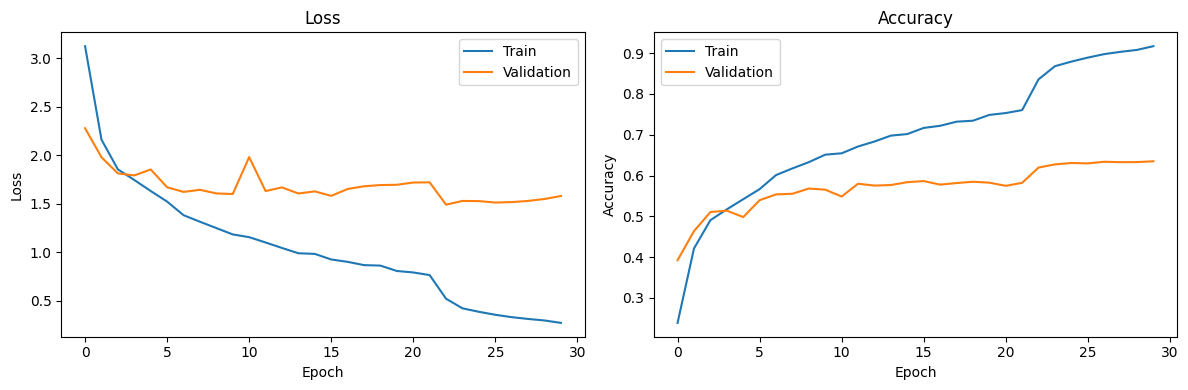

In [10]:
# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Collect all predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    dataset_size = len(dataloader.dataset)
    test_loss = running_loss / dataset_size
    test_acc = running_corrects.double() / dataset_size
    
    print(f'Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}')
    
    return test_loss, test_acc, all_preds, all_labels

# Evaluate on the test set
test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion)

Test Loss: 1.5225 Test Acc: 0.6496


In [12]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, output_dict=True)

# Create a DataFrame from the metrics
rows = []
for cls_str, vals in report.items():
    if cls_str.isdigit():
        i = int(cls_str)
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        rows.append({
            'class': i,
            'class_name': class_names[i] if i < len(class_names) else f"Class {i}",
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'TN': tn,
            'Precision': vals['precision'],
            'Recall': vals['recall'],
            'F1-score': vals['f1-score']
        })

df_metrics = pd.DataFrame(rows).sort_values('class').reset_index(drop=True)
print(df_metrics.head(10))  # Show first 10 classes

# Overall Accuracy
overall_acc = np.trace(cm) / cm.sum()
print(f"\nOverall Test Accuracy: {overall_acc:.4f}")

   class     class_name  TP  FP  FN    TN  Precision  Recall  F1-score
0      0          apple  88  16  12  9884   0.846154    0.88  0.862745
1      1  aquarium_fish  79  22  21  9878   0.782178    0.79  0.786070
2      2           baby  46  45  54  9855   0.505495    0.46  0.481675
3      3           bear  49  59  51  9841   0.453704    0.49  0.471154
4      4         beaver  47  59  53  9841   0.443396    0.47  0.456311
5      5            bed  65  35  35  9865   0.650000    0.65  0.650000
6      6            bee  74  41  26  9859   0.643478    0.74  0.688372
7      7         beetle  70  32  30  9868   0.686275    0.70  0.693069
8      8        bicycle  83  26  17  9874   0.761468    0.83  0.794258
9      9         bottle  72  20  28  9880   0.782609    0.72  0.750000

Overall Test Accuracy: 0.6496


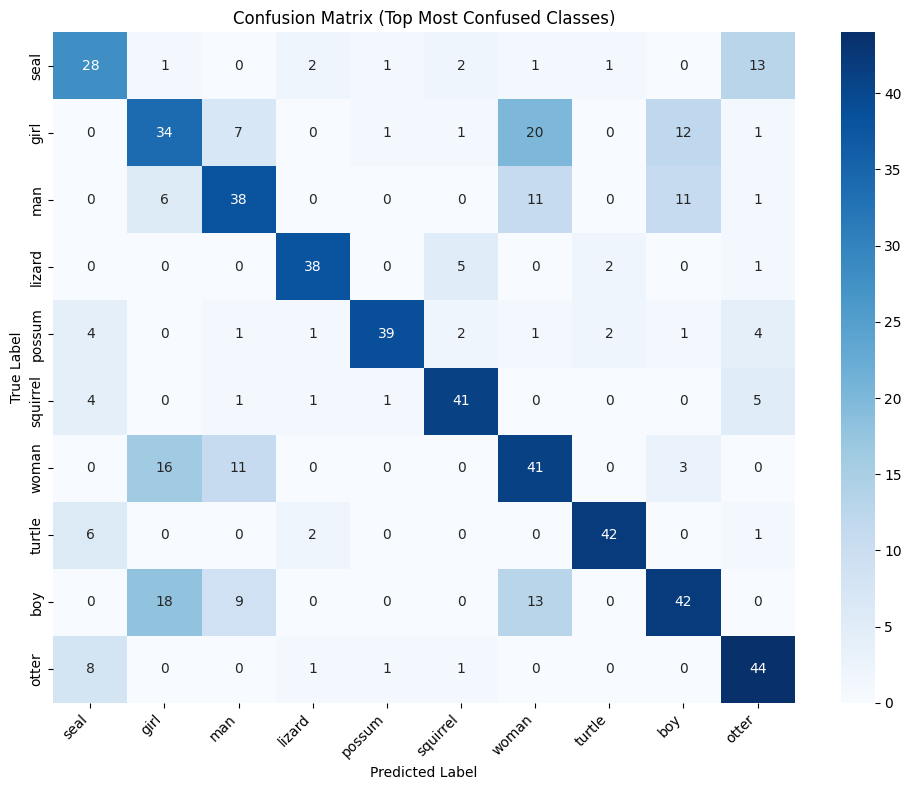

In [13]:
# Plot confusion matrix for top classes (too many classes to show all 100)
plt.figure(figsize=(10, 8))
top_n_classes = 10  # Show top 10 classes

# Get indices of the most confused classes
class_accuracies = [cm[i,i]/cm[i,:].sum() for i in range(len(cm))]
indices = np.argsort(class_accuracies)[:top_n_classes]  # Get indices of lowest accuracy classes

# Create a subset of the confusion matrix
cm_subset = cm[np.ix_(indices, indices)]
class_names_subset = [class_names[i] for i in indices]

# Plot
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_subset, yticklabels=class_names_subset)
plt.title('Confusion Matrix (Top Most Confused Classes)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

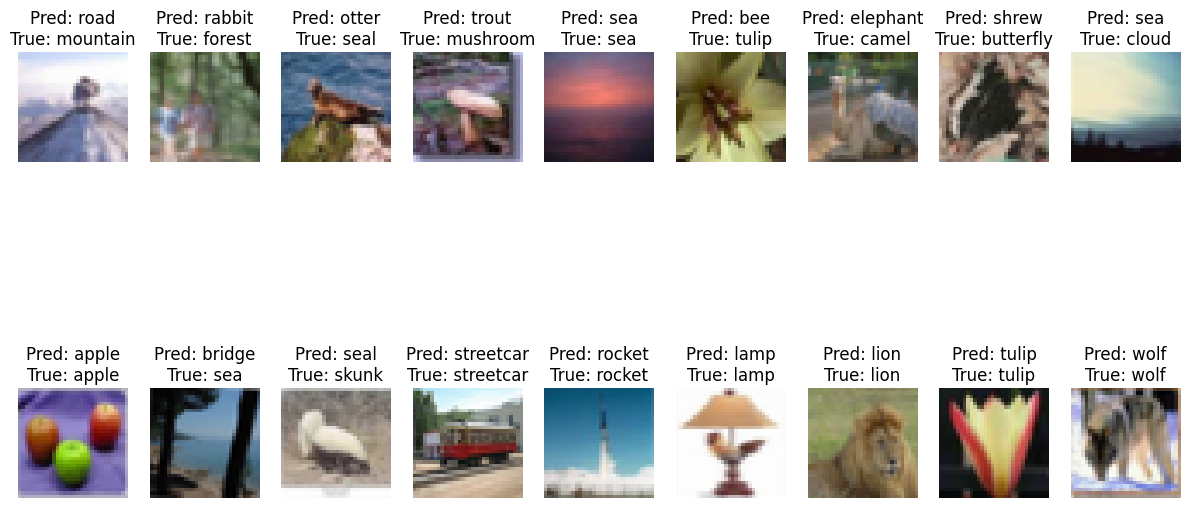

In [14]:
# Display some example predictions
def show_predictions(model, dataloader, class_names, num_images=8):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 8))
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    return
                
                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')
                
                # Convert image for display
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                # Denormalize
                img = img * np.array(cifar100_std) + np.array(cifar100_mean)
                img = np.clip(img, 0, 1)
                
                plt.imshow(img)
    
    plt.tight_layout()
    plt.show()

# Show sample predictions
show_predictions(model, test_loader, class_names, num_images=18)